# Jake New Data -- Dec 17 

In [1]:
from __future__ import print_function
from __future__ import division

import os
import h5py
import numpy as np
import tensorflow as tf
import scipy.io as sio           # importing matlab data
import matplotlib.pyplot as plt  # plotting
%matplotlib inline
from copy import deepcopy
import random
import sys
sys.path.append('C:\\Users\\Jake\\Documents\\')
sys.path.append('C:\\Users\\Jake\\Documents\\NDN3')


# sys.path.append('C:\\Users\\Jake\\Dropbox\\Projects\\NDN\\NDN3')

# sys.path.insert(0, '/Users/dbutts/GitCode/NDN3/')
import NDN3.NDN as NDN
import NDNutils as NDNutils
import Utils.DanUtils as DU
#import NDN.HadiUtils as HU
import Utils.NDNplot as NDNplot
output_dir = 'C:\\Users\\Jake\\Dropbox\\Projects\\NDN\\output_dir'
# output_dir = '/Users/dbutts/Code/PyPlay/tensorboard'
print(sys.version)
import sys
print(sys.path)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(1)



3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
['C:\\Users\\Jake\\.conda\\envs\\NDN\\python36.zip', 'C:\\Users\\Jake\\.conda\\envs\\NDN\\DLLs', 'C:\\Users\\Jake\\.conda\\envs\\NDN\\lib', 'C:\\Users\\Jake\\.conda\\envs\\NDN', '', 'C:\\Users\\Jake\\.conda\\envs\\NDN\\lib\\site-packages', 'C:\\Users\\Jake\\.conda\\envs\\NDN\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Jake\\.ipython', 'C:\\Users\\Jake\\Documents\\', 'C:\\Users\\Jake\\Documents\\NDN3']


In [2]:
# Load data
datadir = "C:\\Users\\Jake\\Dropbox\\Projects\\FreeViewing\\Data\\"
fname = "L20191231_Gabor.mat"

matdat = sio.loadmat(datadir + fname)

In [3]:
stim1 = matdat['stim'] #- np.mean(matdat['stim'])
Robs1 = matdat['Robs']
valdat1 = matdat['valdata']
labels1 = matdat['labels']
valid1 = np.intersect1d(np.where(valdat1[:,0] == 1)[0], np.where(labels1[:,0] == 1)[0])
slist1 = matdat['slist']
dt = matdat['dt'][0][0]
NX = matdat['NX'][0][0]
NP = stim1.shape[1]
NY = NP//NX
NT1,NC = Robs1.shape


matdat = sio.loadmat(datadir + "L20191231_FixRsvpStim.mat")
# matdat = sio.loadmat(datadir + fname)
stim2 = matdat['stim'] - np.mean(matdat['stim']) # note this was not zeroed out
Robs2 = matdat['Robs']
valdat2 = matdat['valdata']
labels2 = matdat['labels']
valid2 = np.intersect1d(np.where(valdat2[:,0] == 1)[0], np.where(labels2[:,0] == 1)[0])
slist2 = matdat['slist']
NT2 = Robs2.shape[0]
print(NT1, NT2, NC,'|', NX, NY)

96989 5275 61 | 40 40


In [4]:
eyeAtFrame = matdat['eyeAtFrame']
eyeXFrame = eyeAtFrame[:,0]-640
eyeYFrame = eyeAtFrame[:,1]-360
# xgood = np.logical_and(eyeXFrame > 0, eyeXFrame < 200)
# ygood = np.logical_and(eyeYFrame > 0, eyeYFrame < 200)
# valid1 = np.intersect1d(valid1, np.where(np.logical_and(xgood,ygood)))
# len(valid1)

In [4]:
# Concatenate data
spaceL = 60
Sspacer = np.zeros([spaceL, NP], dtype='float32')
Rspacer = np.zeros([spaceL, NC], dtype='float32')

Robs = np.concatenate( (Robs1, Rspacer, Robs2), axis=0)
valdata = np.concatenate( (valid1, valid2+NT1+spaceL), axis=0 )
valdata = valid1
stim = np.concatenate( (stim1.copy(), Sspacer.copy(), stim2.copy()), axis=0)
#stim = np.divide( stim-np.mean(stim[valdata,:], axis=0), np.std(stim[valdata,:], axis=0))
stim = np.divide( stim, np.std(stim[valdata,:], axis=0))

NTfull = stim.shape[0]
NT = valdata.shape[0]
# Train and test indices (could be much better....)
Ui, Xi = NDNutils.generate_xv_folds(NT)

# Process saccades -- just store sacc offsets as delta functions
sac_on, sac_off = np.zeros([NTfull,1], dtype='float32'), np.zeros([NTfull,1], dtype='float32')
for nn in range(slist1.shape[0]):
    sac_on[slist1[nn,0]-1] = 1.0
    sac_off[slist1[nn,1]-1] = 1.0
for nn in range(slist2.shape[0]):
    sac_on[slist2[nn,0]-1+NT1+spaceL] = 1.0
    sac_off[slist2[nn,1]-1+NT1+spaceL] = 1.0
    
    

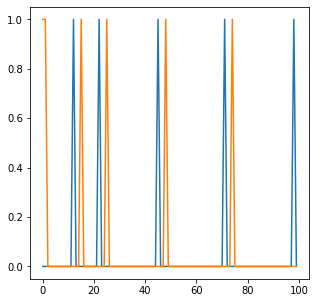

In [15]:
saconsets, sacoffsets = np.zeros([NTfull,1], dtype='float32'), np.zeros([NTfull,1], dtype='float32')

num_pre = 20
saconsets[:(NTfull-num_pre)]=sac_on[num_pre:]
sacoffsets[:(NTfull-num_pre)]=sac_off[num_pre:]

plt.figure(figsize=(5,5))
plt.plot(saconsets[:100])
plt.plot(sac_on[:100])


In [6]:
adam_params = NDN.NDN.optimizer_defaults(opt_params={'use_gpu': True}, learning_alg='adam')

early_stopping = 50

adam_params['batch_size'] = NT // 50
adam_params['display'] = 10
adam_params['epochs_training'] = early_stopping * 100
adam_params['run_diagnostics'] = False

adam_params['epsilon'] = 1e-8
adam_params['early_stop'] = early_stopping
adam_params['early_stop_mode'] = 1
#adam_params['data_pipe_type'] = 'iterator'
adam_params['data_pipe_type'] = 'data_as_var'
adam_params['learning_rate'] = 1e-3
#adam_params['epochs_summary'] = 5
for d in adam_params:
    print("%20s:\t %s" %(d, adam_params[d]))

lbfgs_params = NDN.NDN.optimizer_defaults(opt_params={'use_gpu': True, 'display': True}, learning_alg='lbfgs')
print('\nLBFGS:')
for d in lbfgs_params:
    print("%20s:\t %s" %(d, lbfgs_params[d]))

             use_gpu:	 True
             display:	 10
      data_pipe_type:	 data_as_var
   poisson_unit_norm:	 None
         epochs_ckpt:	 None
       learning_rate:	 0.001
          batch_size:	 1569
     epochs_training:	 5000
     early_stop_mode:	 1
      epochs_summary:	 None
          early_stop:	 50
               beta1:	 0.9
               beta2:	 0.999
             epsilon:	 1e-08
     run_diagnostics:	 False

LBFGS:
             use_gpu:	 True
             display:	 True
      data_pipe_type:	 data_as_var
   poisson_unit_norm:	 None
         epochs_ckpt:	 None
             maxiter:	 500
            func_tol:	 2.220446049250313e-09
            grad_tol:	 1e-05
                 eps:	 1e-08
          batch_size:	 None


## Fitting models

In [7]:
# Time-embedded stimulus -- with wider temporal kernels
num_lags = 8
Xstim = NDNutils.create_time_embedding( stim, [num_lags, NX, NY] )
# pick favorite cell -- fit single model? 

In [8]:
stas = np.reshape(np.matmul(np.transpose(Xstim[valdata,:]),Robs[valdata,:]), [NP,num_lags, NC])
stas.shape

(400, 8, 61)

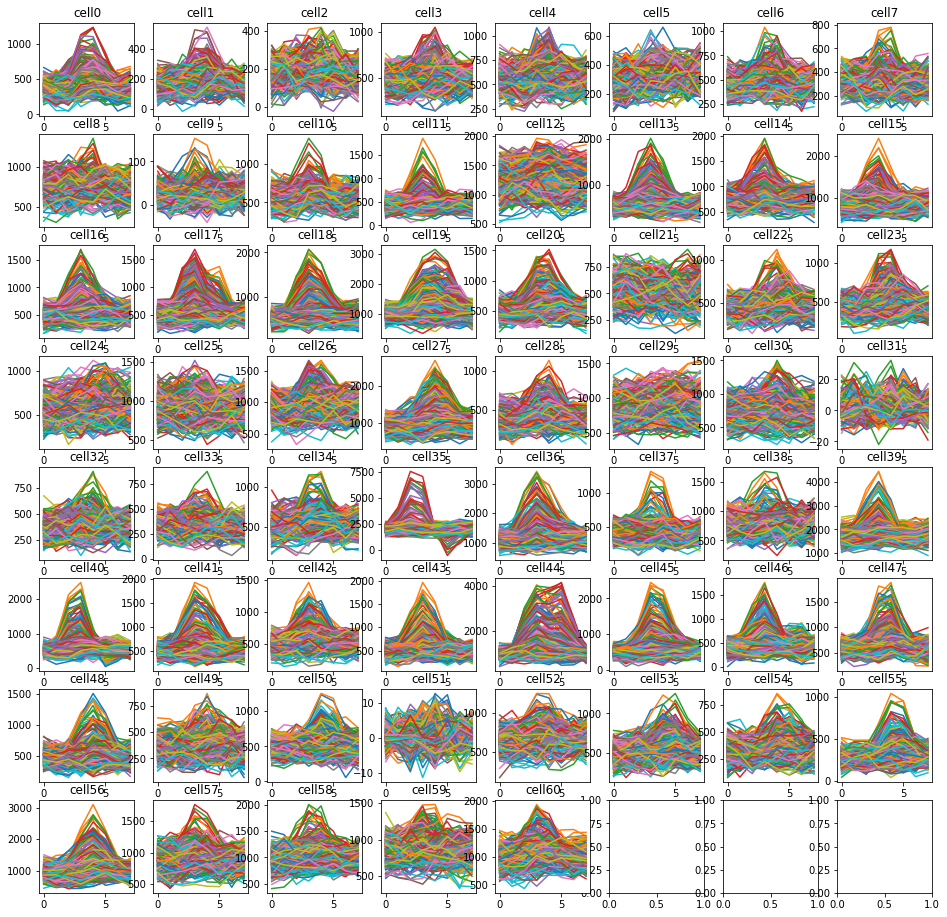

In [9]:
DU.subplot_setup(8,8)
for cc in range(NC):
    plt.subplot(8,8,cc+1)
    plt.plot(np.transpose(stas[:,:,cc]))
    #plt.imshow(np.reshape(stas[:,2,cc], [NY, NX]), cmap='gray',  #RdBu_r 
    #           vmin=-np.max(abs(stas[:,:,cc])), vmax=np.max(abs(stas[:,:,cc])))
    plt.title('cell'+str(cc))
plt.show()

### GLM

In [10]:
# Reg values to begin
XTreg = 1
L1reg = None

In [11]:
# Shared glm model -- fits all 1129 linear receptive fields at once (!) 
glm_par = NDNutils.ffnetwork_params( 
    input_dims=[1,NY,NX, num_lags], layer_sizes=[NC], layer_types=['normal'],
    normalization=[1], act_funcs=['softplus'],
    reg_list={'d2xt':[XTreg], 'l1':[L1reg]})

glm0 = NDN.NDN( glm_par, noise_dist='poisson' )
    
_ = glm0.train(input_data=Xstim[valdata,:], output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi,
                   learning_alg='adam', opt_params=adam_params )

LLs0 = glm0.eval_models(input_data=Xstim[valdata,:], output_data=Robs[valdata,:],
                        data_indxs=Xi, nulladjusted=False)
print(np.mean(LLs0))

Input dimensions: [1, 20, 20, 8]
0: normal (softplus):  	[E61/I0] N
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 0000:  avg train cost =    30.7212,  avg test cost =    26.7536,  reg penalty =     6.3201
Epoch 0009:  avg train cost =    22.1985,  avg test cost =    19.7147,  reg penalty =     0.2998
Epoch 0019:  avg train cost =    18.7367,  avg test cost =    16.7137,  reg penalty =     0.2539
Epoch 0029:  avg train cost =    16.0195,  avg test cost =    14.4521,  reg penalty =     0.2603
Epoch 0039:  avg train cost =    13.9066,  avg test cost =    12.7680,  reg penalty =     0.2760
Epoch 0049:  avg train cost =    12.2271,  avg test cost =    11.4516,  reg penalty =     0.3040
Epoch 0059:  avg train cost =    10.8273,  avg test cost =    10.4391,  reg penalty =     0.3047
Epoch 0069:  avg train cost =     9.5685,  avg test cost =     9.5535,  reg penalty =     0.3283
Epoch 0079:  avg train cost =     8.

In [36]:
LLs0n = glm0.eval_models(input_data=Xstim[valdata,:], output_data=Robs[valdata,:],
                        data_indxs=Xi, nulladjusted=True)
LLs0n

array([ -0.49366784,  -0.3404045 ,  -1.4172945 ,  -0.8445411 ,
        -0.98981524,  -1.0138624 ,  -1.379756  ,  -1.0357096 ,
        -0.7146025 ,   0.25264502,  -1.0864084 ,  -0.76739   ,
         0.41218972,  -0.9187405 ,  -0.6138997 ,  -0.98427033,
        -0.97063994,  -0.9265106 ,  -0.9213214 ,  -0.89621687,
        -0.8151512 ,  -0.51812744,  -0.719779  ,  -0.774457  ,
        -0.1831274 ,  -0.762311  ,  -1.0528603 ,  -0.72672105,
        -0.5467491 ,   0.28636622,   0.24816346, -10.788721  ,
        -1.2037518 ,  -0.8359914 ,  -1.0464277 ,  -0.6815703 ,
        -1.0023723 ,  -2.235509  ,  -1.1907866 ,  -1.1538644 ,
        -0.8170426 ,  -0.52664995,  -1.0065901 ,  -0.84385586,
        -0.6645415 ,  -0.8858659 ,  -1.6235578 ,  -0.9274142 ,
        -0.73416877,  -1.310725  ,  -2.5396235 ,  -3.3536434 ,
        -0.89180875,  -0.8164103 ,  -1.1177263 ,  -3.0183444 ,
        -0.7829652 ,  -1.0666087 ,  -1.228406  ,  -0.54991484,
        -1.2068791 ], dtype=float32)

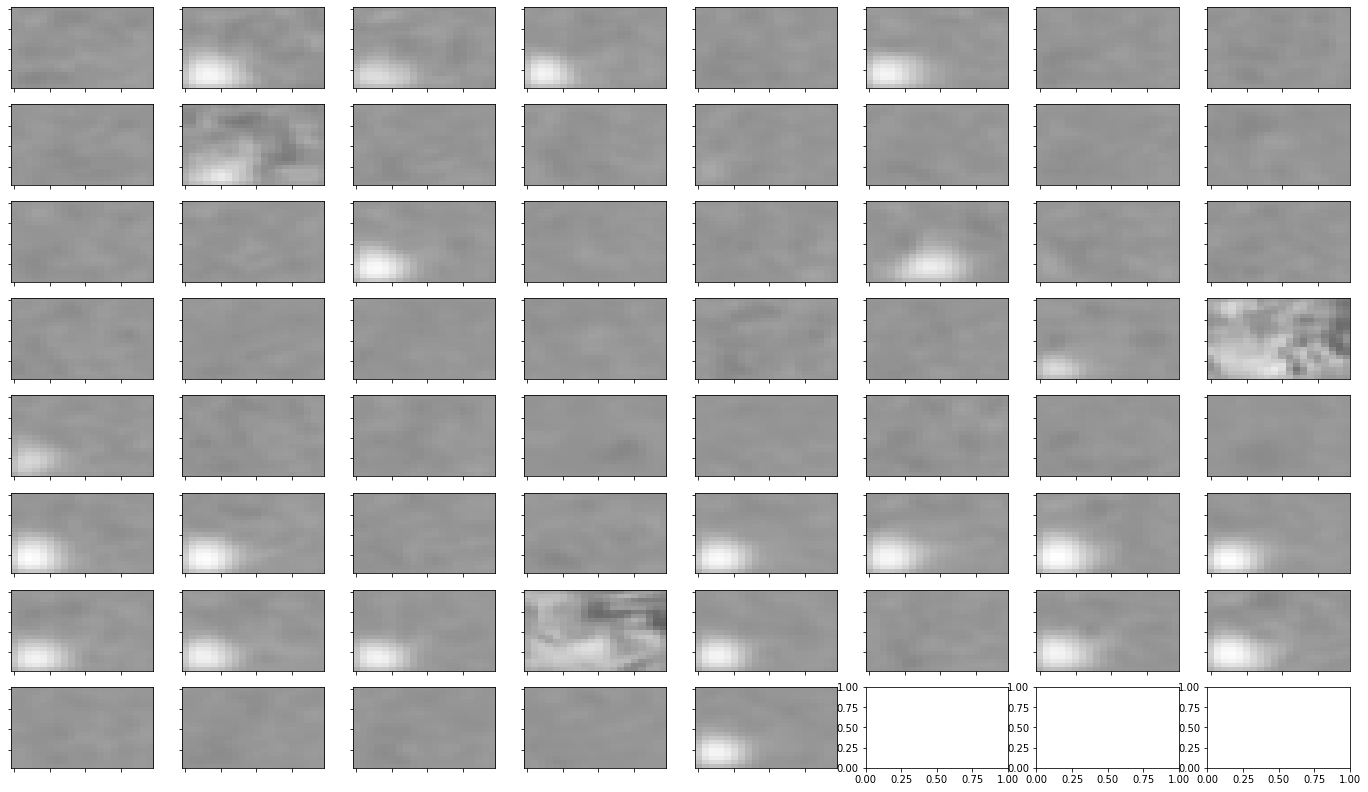

In [14]:
DU.plot_filters(glm0, tbasis_select=0)

In [50]:
glm1 = NDN.NDN( glm_par, noise_dist='poisson' )
    
_ = glm1.train(input_data=Xstim[valdata,:], output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi,
                   learning_alg='lbfgs', opt_params=lbfgs_params )

LLs1 = glm1.eval_models(input_data=Xstim[valdata,:], output_data=Robs[valdata,:],
                        data_indxs=Xi, nulladjusted=False)
np.mean(LLs1)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 113.721512
  Number of iterations: 75
  Number of functions evaluations: 101


3.567202

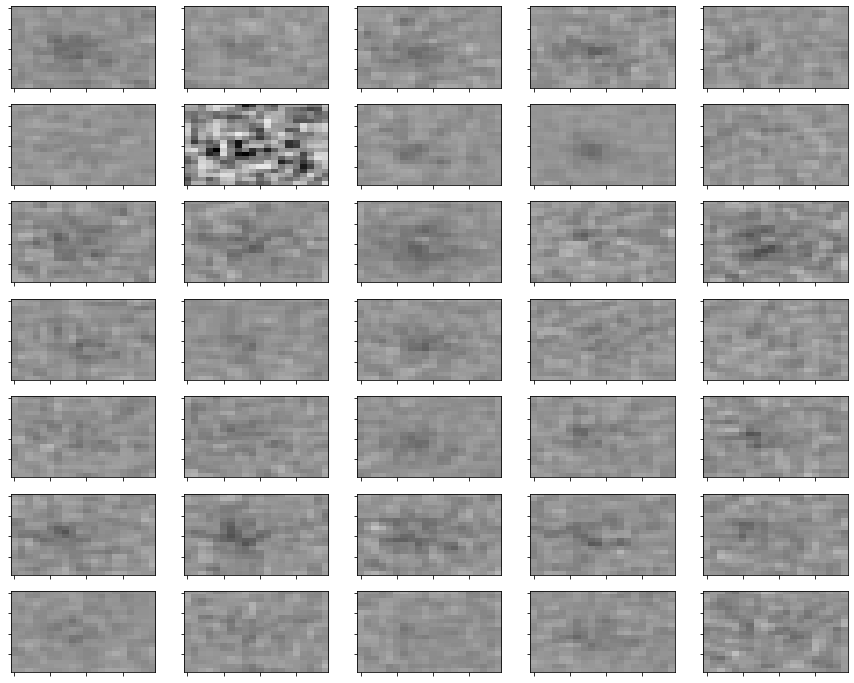

In [52]:
DU.plot_filters(glm1, tbasis_select=3)

### NIM

In [15]:
Treg = 0.2
Xreg = 0.1
L1reg = None

In [21]:
#Share NIM with temporal bases
num_tkerns = 2
num_subs = 20
snim_par = NDNutils.ffnetwork_params( 
    input_dims=[1,NY,NX, num_lags], layer_sizes=[num_tkerns, num_subs, NC], 
    layer_types=['conv', 'normal', 'normal'], conv_filter_widths=[1], 
    normalization=[1,1,0], act_funcs=['lin', 'relu', 'softplus'],
    reg_list={'d2t':[Treg], 'd2x':[None, Xreg], 'l1':[None, L1reg]})

snim0 = NDN.NDN( snim_par, noise_dist='poisson' )
# snim0.networks[0].layers[0].weights = -tkern0.copy() 

_ = snim0.train(input_data=Xstim[valdata,:], output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi,
                   learning_alg='adam', opt_params=adam_params)

LLs0 = snim0.eval_models(input_data=Xstim[valdata,:], output_data=Robs[valdata,:],
                        data_indxs=Xi, nulladjusted=False)
print(np.mean(LLs0))

Input dimensions: [1, 20, 20, 8]
0: conv (lin):  	[E2/I0] N  	filter width = 1
1: normal (relu):  	[E20/I0] N
2: normal (softplus):  	[E61/I0] 
Epoch 0000:  avg train cost =    14.5238,  avg test cost =    14.5048,  reg penalty =     0.4886
Epoch 0009:  avg train cost =     4.0545,  avg test cost =     4.2084,  reg penalty =     0.2234
Epoch 0019:  avg train cost =     3.8711,  avg test cost =     4.0828,  reg penalty =     0.1282
Epoch 0029:  avg train cost =     3.7544,  avg test cost =     4.0014,  reg penalty =     0.0936
Epoch 0039:  avg train cost =     3.6577,  avg test cost =     3.9265,  reg penalty =     0.0821
Epoch 0049:  avg train cost =     3.5935,  avg test cost =     3.8588,  reg penalty =     0.0845
Epoch 0059:  avg train cost =     3.5303,  avg test cost =     3.8097,  reg penalty =     0.0763
Epoch 0069:  avg train cost =     3.4881,  avg test cost =     3.7689,  reg penalty =     0.0710
Epoch 0079:  avg train cost =     3.4585,  avg test cost =     3.7388,  reg pena

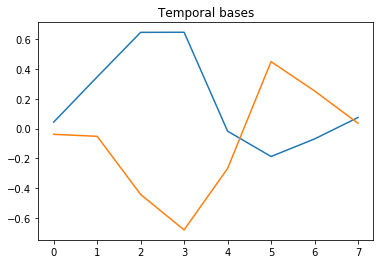

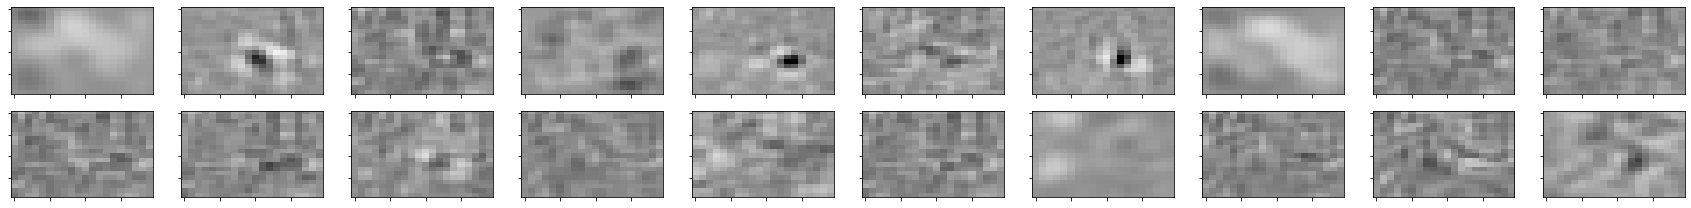

In [22]:
DU.plot_filters(snim0)
# plt.savefig(datadir + "subunits.pdf")

In [84]:
snim0.save_model(datadir + "snim0_1231")

snim0.matlab_export(datadir + "snim0export_1231")

Model pickled to C:\Users\Jake\Dropbox\Projects\FreeViewing\Data\snim0


In [59]:
# add natural image input
valdata = np.concatenate( (valid1, valid2+NT1+spaceL), axis=0 )
NT = valdata.shape[0]
# Train and test indices (could be much better....)
Ui, Xi = NDNutils.generate_xv_folds(NT)


In [60]:
LLs0 = snim0.eval_models(input_data=Xstim[valdata,:], output_data=Robs[valdata,:],
                        data_indxs=Xi, nulladjusted=False)
predrate = snim0.generate_prediction(input_data=Xstim)

In [87]:
sio.savemat(datadir + "snim0_output.mat", dict([ ('LLs0', LLs0), ('predrate', predrate), ('valdata', valdata), ('Robs', Robs), ('sac_on', sac_on), ('sac_off', sac_off)]))


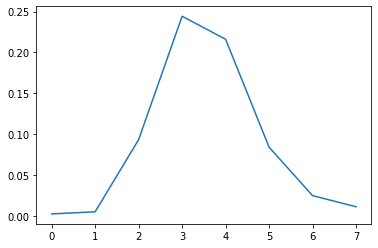

In [18]:
tkern0 = snim0.networks[0].layers[0].weights.copy()
plt.plot(tkern0)
plt.show()

In [19]:
snim1 = snim0.copy_model()
snim1.networks[0].layers[1].normalize_weights = 1
snim1.network_list[0]['normalize_weights'][1] = 1 # not sure necessary
_ = snim1.train(input_data=Xstim[valdata,:], output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi,
                   learning_alg='adam', opt_params=adam_params)

LLs0 = snim1.eval_models(input_data=Xstim[valdata,:], output_data=Robs[valdata,:],
                        data_indxs=Xi, nulladjusted=False)
print(np.mean(LLs0))

Epoch 0000:  avg train cost =     3.4995,  avg test cost =     3.6169,  reg penalty =     0.0160
Epoch 0009:  avg train cost =     3.4269,  avg test cost =     3.6192,  reg penalty =     0.0275
Epoch 0019:  avg train cost =     3.4034,  avg test cost =     3.6283,  reg penalty =     0.0341
Epoch 0029:  avg train cost =     3.3828,  avg test cost =     3.6405,  reg penalty =     0.0356
Epoch 0039:  avg train cost =     3.3650,  avg test cost =     3.6575,  reg penalty =     0.0379
Epoch 0049:  avg train cost =     3.3656,  avg test cost =     3.6587,  reg penalty =     0.0439

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 51,  end cost: 225.811322
     ---> best epoch: 3,  best cost: 220.783198

3.6587875


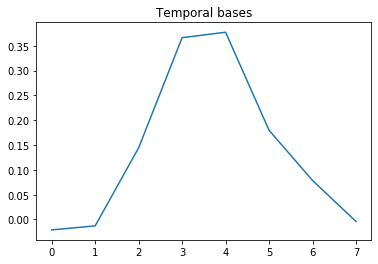

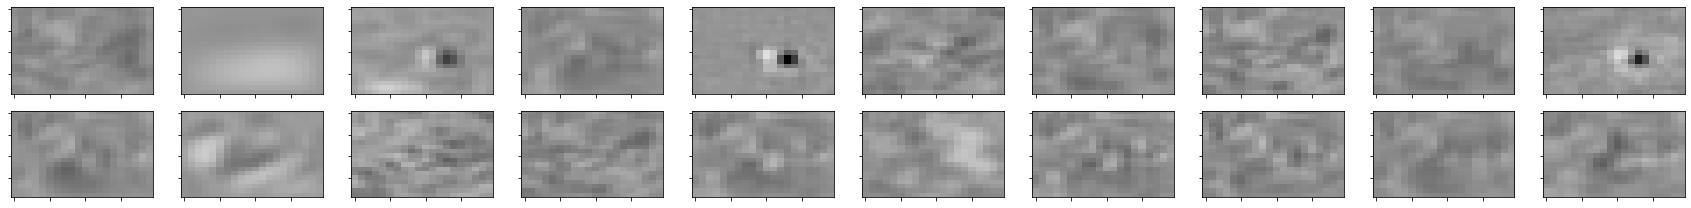

In [20]:
DU.plot_filters(snim1)

In [65]:
snim1.matlab_export(datadir + "snim1export")
LLs0 = snim1.eval_models(input_data=Xstim[valdata,:], output_data=Robs[valdata,:],
                        data_indxs=Xi, nulladjusted=False)
predrate = snim1.generate_prediction(input_data=Xstim)
sio.savemat(datadir + "snim1_output.mat", dict([ ('LLs0', LLs0), ('predrate', predrate), ('valdata', valdata), ('Robs', Robs), ('sac_on', sac_on), ('sac_off', sac_off)]))


In [ ]:
# Ramp up L1
Lreg = 1e-3
curmod = snim1.copy_model()
nsteps = 9
LLsL1 = np.zeros([nsteps,2])
L1mods = []
for nn in range(nsteps):
    curmod.set_regularization('l1', Lreg, layer_target=1)
    _ = curmod.train(input_data=Xstim[valdata,:], output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi,
                     learning_alg='adam', opt_params=adam_params, silent=True )

    LLsL1[nn,0] = np.mean(
        curmod.eval_models(input_data=Xstim[valdata,:], output_data=Robs[valdata,:],
                           data_indxs=Ui, nulladjusted=False))
    LLsL1[nn,1] = np.mean(
        curmod.eval_models(input_data=Xstim[valdata,:], output_data=Robs[valdata,:],
                           data_indxs=Xi, nulladjusted=False))
    print("L1 = %6.4f:  %f\t%f"%(Lreg, LLsL1[nn,0], LLsL1[nn,1]))
    L1mods.append(curmod.copy_model())
    Lreg *= np.sqrt(10)

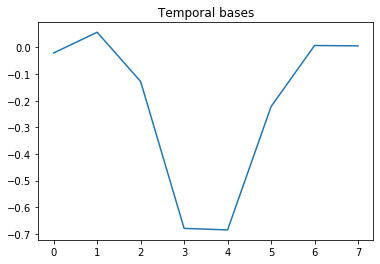

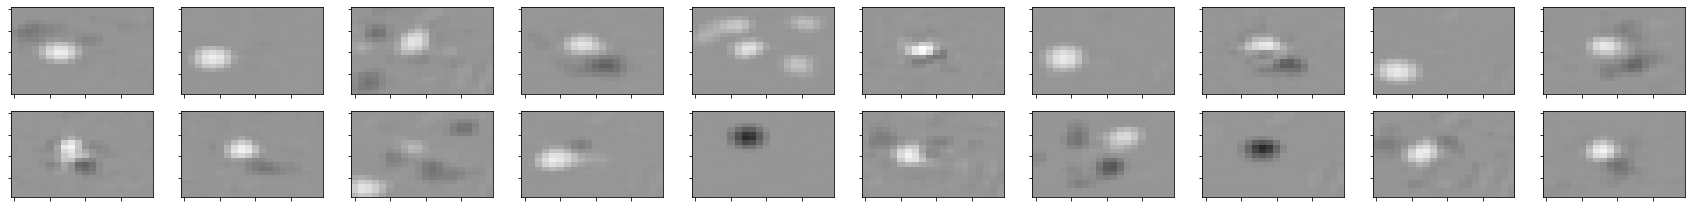

In [32]:
DU.plot_filters(L1mods[5])

In [33]:
LLsN = L1mods[3].eval_models(input_data=Xstim[valdata,:], output_data=Robs[valdata,:],
                             data_indxs=Xi, nulladjusted=True)
print(LLsN)

[ 0.09776163  0.00548339 -0.3062756   0.28929353  0.15725756  0.01676893
  1.1909275   0.21405125 -0.08318996 -0.03290367  0.23109841 -0.31779003
  0.04482293 -0.9061558  -0.11572671 -0.03279376  0.01502442  0.20646214
  0.11011171  0.28208947  0.23690486  0.17975307 -0.10291171  0.29940748
 -0.7571547   0.15576124 -0.09095168  0.32136393 -0.11008692  0.30766296
 -0.11527586  0.2708273   0.19941068  0.22588754  0.30368853]


In [128]:
# Try the whole thing with less L1 
# Ramp up L1
Lreg = 1e-4
curmod = snim1.copy_model()
curmod.set_regularization('d2x',0.01,layer_target=1)
nsteps = 5
LLsL1B = np.zeros([nsteps,2])
L1modsB = []
for nn in range(nsteps):
    curmod.set_regularization('l1', Lreg, layer_target=1)
    _ = curmod.train(input_data=Xstim[valdata,:], output_data=Robs[valdata,:], train_indxs=Ui, test_indxs=Xi,
                     learning_alg='adam', opt_params=adam_params, output_dir=output_dir, silent=True )

    LLsL1B[nn,0] = np.mean(
        curmod.eval_models(input_data=Xstim[valdata,:], output_data=Robs[valdata,:],
                           data_indxs=Ui, nulladjusted=False))
    LLsL1B[nn,1] = np.mean(
        curmod.eval_models(input_data=Xstim[valdata,:], output_data=Robs[valdata,:],
                           data_indxs=Xi, nulladjusted=False))
    print("L1 = %6.4f:  %f\t%f"%(Lreg, LLsL1B[nn,0], LLsL1B[nn,1]))
    L1modsB.append(curmod.copy_model())
    Lreg *= np.sqrt(10)

L1 = 0.0001:  3.242483	3.494643


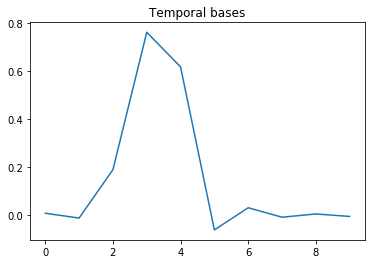

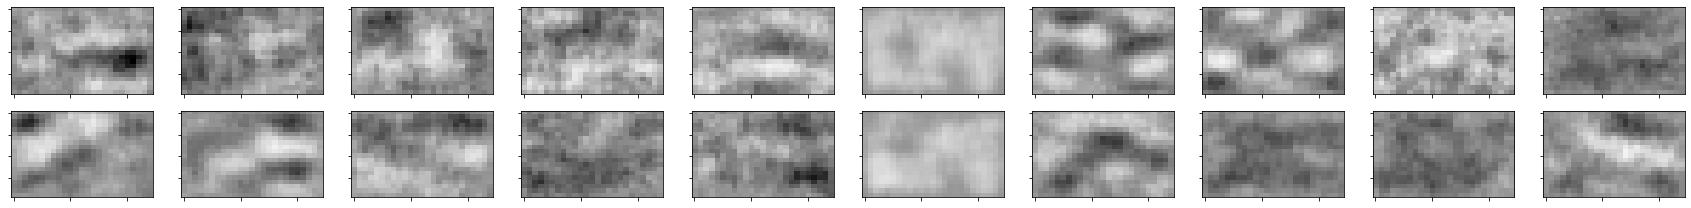

In [143]:
DU.plot_filters(L1modsB[3])

In [ ]:
# not enough d2x....

## Single neuron: based on positive cross-validation

In [34]:
np.where(LLsN>0)[0]

array([ 0,  1,  3,  4,  5,  6,  7, 10, 12, 16, 17, 18, 19, 20, 21, 23, 25,
       27, 29, 31, 32, 33, 34], dtype=int64)

In [35]:
cc= 7
R = Robs[valdata,cc]

In [41]:
# Start GLM
num_tkerns=1
Treg = 0.01
tglm1_par = NDNutils.ffnetwork_params( 
    input_dims=[1,NY,NX, num_lags], layer_sizes=[num_tkerns, 1], layer_types=['conv', 'normal'],
    normalization=[1, 0], act_funcs=['lin', 'softplus'], conv_filter_widths=[1],
    reg_list={'d2t':[Treg], 'd2x':[None, Xreg], 'l1':[None, L1reg]})

glm0 = NDN.NDN( tglm1_par, noise_dist='poisson' )
glm0.networks[0].layers[0].weights = tkern0.copy()

_ = glm0.train(input_data=Xstim[valdata,:], output_data=R, train_indxs=Ui, test_indxs=Xi,
                   learning_alg='lbfgs', opt_params=lbfgs_params )

LL0 = glm0.eval_models(input_data=Xstim[valdata,:], output_data=R, data_indxs=Xi, nulladjusted=False)
LL0n = glm0.eval_models(input_data=Xstim[valdata,:], output_data=R, data_indxs=Xi, nulladjusted=True)

print(LL0, LL0n)

Input dimensions: [1, 20, 20, 8]
0: conv (lin):  	[E1/I0] N  	filter width = 1
1: normal (softplus):  	[E1/I0] 
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 2.824787
  Number of iterations: 323
  Number of functions evaluations: 410
[2.7782567] [0.07598948]


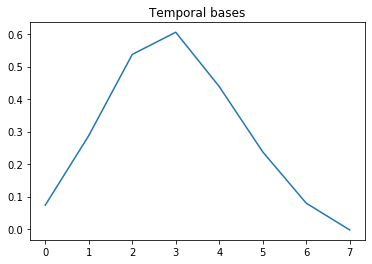

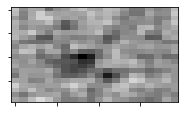

In [42]:
DU.plot_filters(glm0)

In [153]:
# Start NIM
num_tkerns=1
num_subs = 4
tnim1_par = NDNutils.ffnetwork_params( 
    input_dims=[1,NY,NX, num_lags], layer_sizes=[num_tkerns, num_subs, 1], layer_types=['conv', 'normal', 'normal'],
    normalization=[1, 1, 0], act_funcs=['lin', 'relu', 'softplus'], conv_filter_widths=[1],
    reg_list={'d2t':[Treg], 'd2x':[None, Xreg], 'l1':[None, L1reg]})

nim0 = NDN.NDN( tnim1_par, noise_dist='poisson' )
nim0.networks[0].layers[0].weights = tkern0.copy()

_ = nim0.train(input_data=Xstim[valdata,:], output_data=R, train_indxs=Ui, test_indxs=Xi,
                   learning_alg='lbfgs', opt_params=lbfgs_params )

LL1 = nim0.eval_models(input_data=Xstim[valdata,:], output_data=R, data_indxs=Xi, nulladjusted=False)
LL1n = nim0.eval_models(input_data=Xstim[valdata,:], output_data=R, data_indxs=Xi, nulladjusted=True)

print(LL1, LL1n)

Input dimensions: [1, 20, 25, 10]
0: conv (lin):  	[E1/I0] N  	filter width = 1
1: normal (relu):  	[E4/I0] N
2: normal (softplus):  	[E1/I0] 
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 3.324469
  Number of iterations: 500
  Number of functions evaluations: 554
[3.1924052] [0.154562]


In [157]:
nim0.set_regularization('d2x', 0.01, layer_target=1)
_ = nim0.train(input_data=Xstim[valdata,:], output_data=R, train_indxs=Ui, test_indxs=Xi,
                   learning_alg='lbfgs', opt_params=lbfgs_params )

LL1 = nim0.eval_models(input_data=Xstim[valdata,:], output_data=R, data_indxs=Xi, nulladjusted=False)
LL1n = nim0.eval_models(input_data=Xstim[valdata,:], output_data=R, data_indxs=Xi, nulladjusted=True)

print(LL1, LL1n)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 3.301308
  Number of iterations: 500
  Number of functions evaluations: 560
[3.2266293] [0.12033796]


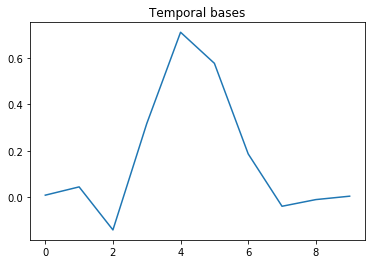

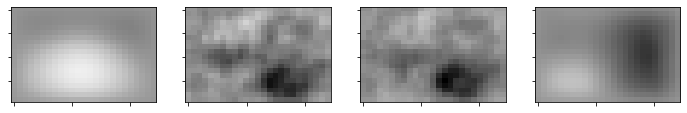

In [158]:
DU.plot_filters(nim0)

## ADD SACCADE KERNELS

In [185]:
num_saclags = 20
Xsac1 = NDNutils.create_time_embedding(sac_on, [num_saclags, 1, 1], tent_spacing=2)
Xsac2 = NDNutils.create_time_embedding(sac_off, [num_saclags, 1, 1], tent_spacing=2)

In [182]:
STreg = 0.01
num_tkerns = 1
tnim1_par = NDNutils.ffnetwork_params( 
    input_dims=[1,NY,NX, num_lags], xstim_n=[0], layer_sizes=[num_tkerns, num_subs], 
    layer_types=['conv', 'normal'], normalization=[1, 1], act_funcs=['lin', 'relu'], conv_filter_widths=[1],
    reg_list={'d2t':[Treg], 'd2x':[None, Xreg], 'l1':[None, L1reg]})
sac1_par = NDNutils.ffnetwork_params( 
    input_dims=[1,1,1, num_saclags], xstim_n=[1],
    layer_sizes=[1], layer_types=['normal'], normalization=[0], act_funcs=['lin'],
    reg_list={'d2t':[STreg]})
sac2_par = NDNutils.ffnetwork_params( 
    input_dims=[1,1,1, num_saclags], xstim_n=[2],
    layer_sizes=[1], layer_types=['normal'], normalization=[0], act_funcs=['lin'],
    reg_list={'d2t':[STreg]})
comb_par = NDNutils.ffnetwork_params( 
    xstim_n=None, ffnet_n=[0,1,2], layer_sizes=[1], layer_types=['add'], act_funcs=['softplus'])

sacnim0 = NDN.NDN( [tnim1_par, sac1_par, sac2_par, comb_par], ffnet_out=3, noise_dist='poisson' )
sacnim0.networks[0].layers[0].weights = tkern0.copy()

_ = sacnim0.train(input_data=[Xstim[valdata,:], Xsac1[valdata,:], Xsac2[valdata,:]], output_data=R, 
                  train_indxs=Ui, test_indxs=Xi, learning_alg='lbfgs', opt_params=lbfgs_params )

LL1 = sacnim0.eval_models(input_data=[Xstim[valdata,:], Xsac1[valdata,:], Xsac2[valdata,:]], output_data=R,
                          data_indxs=Xi, nulladjusted=False)
LL1n = sacnim0.eval_models(input_data=[Xstim[valdata,:], Xsac1[valdata,:], Xsac2[valdata,:]], output_data=R, 
                           data_indxs=Xi, nulladjusted=True)

print(LL1, LL1n)

Input dimensions: [1, 20, 25, 10]
0: conv (lin):  	[E1/I0] N  	filter width = 1
1: normal (relu):  	[E4/I0] N
Input dimensions: [1, 1, 1, 16]
0: normal (lin):  	[E1/I0] 
Input dimensions: [1, 1, 1, 16]
0: normal (lin):  	[E1/I0] 
0: add (softplus):  	[E1/I0] 
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 3.292627
  Number of iterations: 500
  Number of functions evaluations: 543
[3.228721] [0.11824632]


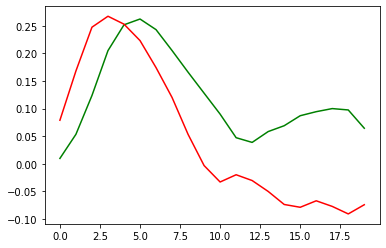

[[0.32565945]
 [0.34328684]
 [0.44520476]
 [0.3958331 ]
 [1.3789041 ]
 [1.3469502 ]]


In [196]:
plt.plot(sacnim0.networks[1].layers[0].weights,'g')
plt.plot(sacnim0.networks[2].layers[0].weights,'r')
plt.show()
print(sacnim0.networks[3].layers[0].weights)

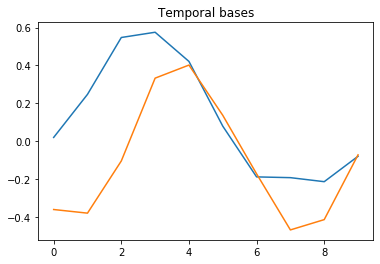

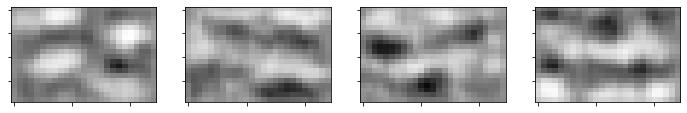

In [191]:
DU.plot_filters(sacnim0)

In [194]:
STreg = 0.01
Treg = 0.001
num_tkerns=2
tnim1_par = NDNutils.ffnetwork_params( 
    input_dims=[1,NY,NX, num_lags], xstim_n=[0], layer_sizes=[num_tkerns, num_subs], 
    layer_types=['conv', 'normal'], normalization=[1, 1], act_funcs=['lin', 'relu'], conv_filter_widths=[1],
    reg_list={'d2t':[Treg], 'd2x':[None, Xreg], 'l1':[None, L1reg]})
sac1_par = NDNutils.ffnetwork_params( 
    input_dims=[1,1,1, num_saclags], xstim_n=[1],
    layer_sizes=[1], layer_types=['normal'], normalization=[0], act_funcs=['lin'],
    reg_list={'d2t':[STreg]})
sac2_par = NDNutils.ffnetwork_params( 
    input_dims=[1,1,1, num_saclags], xstim_n=[2],
    layer_sizes=[1], layer_types=['normal'], normalization=[0], act_funcs=['lin'],
    reg_list={'d2t':[STreg]})
comb_par = NDNutils.ffnetwork_params( 
    xstim_n=None, ffnet_n=[0,1,2], layer_sizes=[1], layer_types=['add'], act_funcs=['softplus'])

sacnim0 = NDN.NDN( [tnim1_par,sac1_par,sac2_par, comb_par], ffnet_out=3, noise_dist='poisson' )
sacnim0.networks[0].layers[0].weights[:,0] = tkern0[:,0].copy()

_ = sacnim0.train(input_data=[Xstim[valdata,:], Xsac1[valdata,:], Xsac2[valdata,:]], output_data=R, 
                  train_indxs=Ui, test_indxs=Xi, learning_alg='adam', 
                  opt_params=adam_params )

LL1 = sacnim0.eval_models(input_data=[Xstim[valdata,:], Xsac1[valdata,:], Xsac2[valdata,:]], output_data=R,
                          data_indxs=Xi, nulladjusted=False)
LL1n = sacnim0.eval_models(input_data=[Xstim[valdata,:], Xsac1[valdata,:], Xsac2[valdata,:]], output_data=R, 
                           data_indxs=Xi, nulladjusted=True)

print(LL1, LL1n)

Input dimensions: [1, 20, 25, 10]
0: conv (lin):  	[E2/I0] N  	filter width = 1
1: normal (relu):  	[E4/I0] N
Input dimensions: [1, 1, 1, 20]
0: normal (lin):  	[E1/I0] 
Input dimensions: [1, 1, 1, 20]
0: normal (lin):  	[E1/I0] 
0: add (softplus):  	[E1/I0] 
Epoch 0000:  avg train cost =     7.9870,  avg test cost =     8.2160,  reg penalty =     0.7802
Epoch 0009:  avg train cost =     4.0267,  avg test cost =     4.0384,  reg penalty =     0.1976
Epoch 0019:  avg train cost =     3.4062,  avg test cost =     3.3152,  reg penalty =     0.0546
Epoch 0029:  avg train cost =     3.3590,  avg test cost =     3.2500,  reg penalty =     0.0336
Epoch 0039:  avg train cost =     3.3342,  avg test cost =     3.2265,  reg penalty =     0.0269
Epoch 0049:  avg train cost =     3.3159,  avg test cost =     3.2108,  reg penalty =     0.0232
Epoch 0059:  avg train cost =     3.3013,  avg test cost =     3.2051,  reg penalty =     0.0213
Epoch 0069:  avg train cost =     3.2940,  avg test cost =   

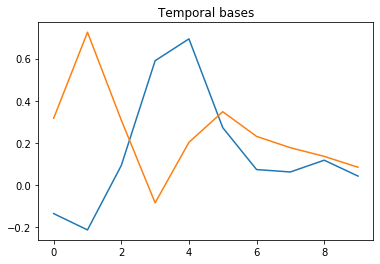

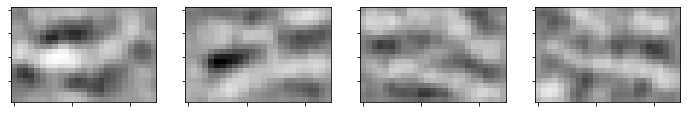

In [195]:
DU.plot_filters(sacnim0)

In [ ]:
# Ramp up L1
Lreg = 1e-4
curmod = sacnim0.copy_model()
nsteps = 7
LLsL1 = np.zeros([nsteps,2])
L1mods = []
for nn in range(nsteps):
    curmod.set_regularization('l1', Lreg, ffnet_target=0, layer_target=1)
    _ = curmod.train(input_data=[Xstim[valdata,:], Xsac1[valdata,:], Xsac2[valdata,:]], output_data=R, 
                  train_indxs=Ui, test_indxs=Xi, learning_alg='lbfgs', opt_params=lbfgs_params )

    LLsL1B[nn,0] = sacnim0.eval_models(input_data=[Xstim[valdata,:], Xsac1[valdata,:], Xsac2[valdata,:]], 
                                       output_data=R, data_indxs=Ui, nulladjusted=False)
    LLsL1B[nn,1] = sacnim0.eval_models(input_data=[Xstim[valdata,:], Xsac1[valdata,:], Xsac2[valdata,:]], 
                                       output_data=R, data_indxs=Xi, nulladjusted=False)

    print("L1 = %6.4f:  %f\t%f"%(Lreg, LLsL1B[nn,0], LLsL1B[nn,1]))
    L1modsB.append(curmod.copy_model())
    Lreg *= np.sqrt(10)